# Análise Titanic


Neste notebook iremos trabalhar com a base de dados dos passageiros do Titanic. O foco é avaliar os modelos para previsão se um passageiro sobreviverá ou não. 

## Etapa preliminar

A primeira etapa é carregar a base de dados. 

In [35]:
import pandas as pd

dados = pd.read_excel('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls')

dados.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


A segunda etapa é verificar os dados faltantes

In [38]:
## Criar variável "familia" como a soma entre 'sibsp' e 'parch'
dados['familia'] = dados['sibsp'] + dados['parch'] 

dados.info()

dados.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
familia      1309 non-null int64
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
familia         0
dtype: int64

Podemos verificar que algumas colunas do banco de dados (as features) possuem valores faltantes. A coluna idade ('age') tem 263 casos com dados faltantes.

Mas antes de tratar esses dados faltantes, iremos dividir os dados entre base de treino e base de teste.


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dados.iloc[:,dados.columns.values !='survived'], dados['survived'], test_size=0.33, random_state=42)

Após Vamos substituir os casos com dados faltantes com o valor da mediana da idade.


In [40]:
## Inserir Idades faltantes com a Mediana
X_train['age'].fillna(X_train['age'].median(), inplace = True)
X_test['age'].fillna(X_test['age'].median(), inplace = True)


## Gráficos descritivos

A seguir temos alguns gráficos descritivos das variáveis que serão utilizadas

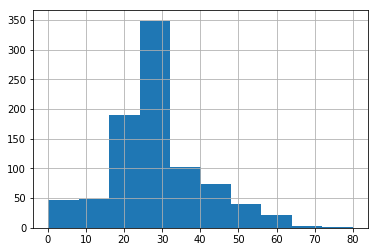

In [41]:
% matplotlib inline
X_train['age'].hist()

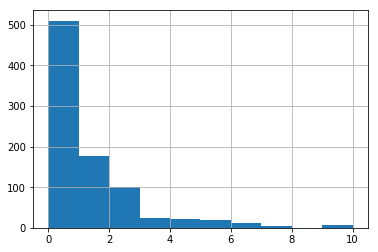

In [42]:
X_train['familia'].hist()

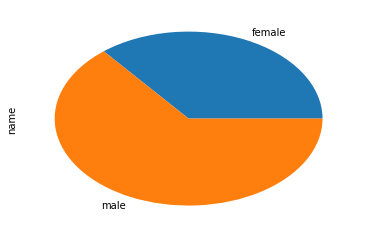

In [43]:
X_train.groupby(['sex']).count()['name'].plot.pie()

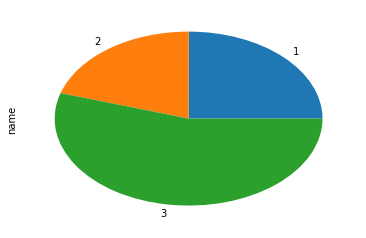

In [44]:
X_train.groupby(['pclass']).count()['name'].plot.pie()

A próxima etapa é transformar as variáveis qualitativas em binárias (dummies)

In [45]:
X_train = pd.get_dummies(X_train, columns=["pclass","sex"])
X_test = pd.get_dummies(X_test, columns=["pclass","sex"])


#Apagar as dummies que servirão de base
del X_train['sex_female']
del X_train['pclass_1']

del X_test['sex_female']
del X_test['pclass_1']

## Rodar modelos

A partir de agora iremos rodar alguns modelos disponíveis no pacote Scikit Learn. Nesta primeira análise não iremos nos preocupar com o possível Overfitting dos modelos (ao não separar a base de dados entre treino e teste).

Também não iremos 'otimizar' os códigos de maneira que não fiquem repetivivos. Esta primeira parte 
(a partir da segunda parte, iremos 'otimizar' o código)


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tabela com resultados finais
resultados_acuracia = pd.DataFrame(columns = ['modelo', 'acuracia'])

### Regressão Logística

In [47]:
from sklearn.linear_model import LogisticRegression

# Modelo
regressao_logistica = LogisticRegression(fit_intercept = True)
regressao_logistica.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)
regressao_logistica.intercept_[0]
regressao_logistica.coef_[0]

# Resultados
previsto = regressao_logistica.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

tn, fp, fn, tp = confusion_matrix(y_test,previsto).ravel()

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'lr_sklearn', 'acuracia':acuracia}, ignore_index = True)

### KNN (K Nearest Neighbors)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# Modelo
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Resultados
previsto = knn.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'knn', 'acuracia':acuracia}, ignore_index = True)


### Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

# Modelo
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Resultados
previsto = gaussian_nb.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'naive_bayes', 'acuracia':acuracia}, ignore_index = True)


### Análise Discriminante

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modelo
discriminante = LinearDiscriminantAnalysis()
discriminante.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Resultados
previsto = discriminante.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'lda', 'acuracia':acuracia}, ignore_index = True)


### SVM (Support Vector Machine)

In [51]:
from sklearn import svm

# Modelo
modelo_svm = svm.SVC(gamma=0.1, C=1.0)
modelo_svm.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Resultados
previsto = modelo_svm.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'svm', 'acuracia':acuracia}, ignore_index = True)


### Árvore de Decisão

In [52]:
from sklearn.tree import DecisionTreeClassifier

# Modelo
arvore = DecisionTreeClassifier()
arvore.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Resultados
previsto = arvore.predict(X_test[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(y_test,previsto)
confusion_matrix(y_test,previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'tree', 'acuracia':acuracia}, ignore_index = True)


In [53]:
resultados_acuracia

,modelo,acuracia
0,lr_sklearn,0.803241
1,knn,0.692130
2,naive_bayes,0.782407
3,lda,0.800926
4,svm,0.793981
5,tree,0.740741
